In [3]:
import functions
#exec(open('./functions.py').read())
%run functions.py
import demoji
#demoji.download_codes()

[nltk_data] Downloading package stopwords to C:\Users\Annelie
[nltk_data]     Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Annelie
[nltk_data]     Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Annelie
[nltk_data]     Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#load labelled data (generated in file 2.preprocessing_en)
data = pickle.load(open('data_n_models/eng_df_labelled.pkl', "rb"))

#filter out bot reated data

def classify_bots(df):
    #collect all the account names related to bots and scripts
    names = []
    pat = r'(bot\s|script|bot_)'
    for name in df.name.unique():
        match = re.findall(pat, name, re.IGNORECASE) 
        if len(match) > 0:
            names.append(name)
    #look for a key words to identify a tweet related to bots and scripts
    pattern = r"(script|bot\s|bots\s|bot_|cook|cop^e|destroy|proxy)"
    df['bot'] = False
    for i, row in df.iterrows():
        match = re.findall(pattern, row.tweet, re.IGNORECASE) 
        if len(match) > 0 or row.isin(names)['name'] == True:
            df['bot'].loc[i] = True
    return df
data = classify_bots(data)
data = data[data['bot']==False]

#additional cleaning
data['lemma']=[strip_multiple_whitespaces(c) for c in data['lemma']]
#data['lemma']=clean_complete(data.lemma)

#dropping duplicates based only on lemmatized text
data = data.drop_duplicates(subset=['lemma'])
data.head()

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,user_id,user_statuses,name,tweet,retweets,location,created,followers,is_user_verified,favorite_count,in_reply_to_status_id,keyword,language,clean,clean_vader,compound,lemma,bot
0,0,819101311715131392,77,Ali09685762,@Zalando give me my money you owe me!!!,0,,07-Mar-2021,6,False,0.0,NaN,zalando,en,money owe,give money you owe me!!!,0.0000,money owe,False
1,1,1189512849472643072,105,Labellerr1,#VirtualStyling and try-on increases the conve...,0,chandigarh,06-Mar-2021,18,False,0.0,NaN,zalando,en,virtualstyling try increases conversion rate l...,VirtualStyling and try-on increases the conver...,0.7650,virtualstyle try increase conversion rate larg...,False
3,3,1125728513666048000,9604,DommeLineCoUk,@missbellalugosi @Zalando Problem starts at Ad...,0,,06-Mar-2021,2193,False,1.0,1.368196e+18,zalando,en,problem starts adidas selling latex websites,Problem starts Adidas. They're selling latex t...,-0.4019,problem start adida sell latex website,False
4,4,2614256724,35470,medboyUK,@missbellalugosi @Zalando Welcome to my world ...,0,"West Midlands, UK",06-Mar-2021,2503,False,1.0,1.368196e+18,zalando,en,welcome world sneering disdain,Welcome world sneering and disdain!,-0.1007,welcome world sneer disdain,False
5,5,978410484155199488,1549,missbellalugosi,Hey @Zalando these clothes are not made of la...,0,GERMANY / UK / USA,06-Mar-2021,13827,False,17.0,NaN,zalando,en,hey clothes latex plastic latex rubber stitche...,"Hey these clothes are not made latex, they are...",0.5362,hey clothe latex plastic latex rubber stitch r...,False


In [6]:
for i, value in data[10:20].lemma.iteritems():
    print(i, value)

12 send delivery paper bag
13 order eventually thing happen expectation feed information whomever concerned zalando
14 hey order product web shop item " fast delivery " suppose arrive today unfortunately ship parcel time happen sad
15 zalando think big pregnant suggest lovely maternity clothe ️ ️ ️ ️ ️ ️ ️ thank love ️ ️ ️ ️
16 think belong sport shoe section
17 new redezign circularity pilot product product pilot equip digital tag save product datum scan able discover product history digital product site ️ ️
18 zalando ride cargo bike delivery service netherland
19 order ship able provide status update
20 check new cto cto podcast format dedicate impactful tech in episode victoria schmierer share story implement pre own give new life clothe ecommerce sustainability reuse rewear
21 stay informed circular csnew energylabel come force march help consumer cut energy bill footprint zircle wardrobe future list ️ circulareconomy sdg


# clustering with LatentDirichletAllocation

https://ourcodingclub.github.io/tutorials/topic-modelling-python/

# on the whole dataset

In [7]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=30, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(data['lemma']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [8]:
 # Each row is a tweet and each column is a word. The numbers in each position tell us how many times this word appears in this tweet.
 tf

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
print(tf_feature_names)

['"', "'", 'a', 'able', 'absolute', 'absolutely', 'abt', 'abuse', 'acc', 'accept', 'access', 'accessory', 'accident', 'accidentally', 'accord', 'account', 'act', 'action', 'active', 'actual', 'actually', 'ad', 'add', 'addict', 'addiction', 'address', 'adida', 'admin', 'admire', 'admit', 'adorable', 'adult', 'advert', 'advertise', 'advertising', 'advice', 'advise', 'adwd', 'affect', 'afford', 'affordable', 'afraid', 'afternoon', 'age', 'agent', 'ago', 'agree', 'ahead', 'ahh', 'ahhh', 'ai', 'aid', 'ain', 'air', 'airport', 'album', 'aliexpress', 'all', 'allow', 'alright', 'alternative', 'amazing', 'amazon', 'america', 'american', 'angel', 'angry', 'animal', 'ankle', 'announce', 'annoy', 'annoyed', 'annoying', 'answer', 'anthropologie', 'anti', 'anybody', 'anymore', 'anyways', 'apart', 'apology', 'app', 'apparently', 'appear', 'apple', 'application', 'apply', 'appreciate', 'approach', 'april', 'area', 'aren', 'argo', 'argue', 'argument', 'arm', 'arrive', 'art', 'article', 'artist', 'asap',

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 9

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [11]:
model.fit(tf)

LatentDirichletAllocation(n_components=9, random_state=0)

In [12]:
#	Calculate approximate log-likelihood as score.
model.score(tf)

-2628505.0207069693

a function which takes in our model object model, the order of the words in our matrix tf_feature_names and the number of words we would like to show. Use this function, which returns a dataframe, to show you the topics we created. Remember that each topic is a list of words/tokens and weights

In [13]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [14]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights
0,boohoo,2111.5,️,2632.1,asos,7568.1,asos,4066.8,boohoo,10492.5,’t,5900.0,order,5026.3,love,2311.6,i,1464.1
1,"""",2087.8,myasosluck,1156.5,buy,1567.6,’,2492.6,like,1353.3,n,5894.0,day,2204.6,check,2200.1,asosiwd,1273.1
2,like,1349.7,win,1152.4,size,1527.9,it,2082.3,people,1101.1,do,3114.9,i,1908.3,asos,2145.9,year,1231.8
3,girl,1286.8,asos,1129.9,clothe,1105.1,’s,1281.0,man,716.7,ca,1029.1,delivery,1803.0,good,1938.5,’m,1098.4
4,look,1170.2,boohootreat,1054.1,shop,868.3,thank,1044.7,cry,689.1,be,900.1,return,1747.1,poshmark,1467.1,work,1043.5
5,’re,1030.5,‍,898.1,like,867.2,code,738.1,get,668.6,have,869.5,send,1568.3,shopmycloset,1456.1,friend,467.7
6,you,833.5,new,855.3,sale,852.0,zalando,649.9,baby,638.6,nt,683.3,help,1421.1,fashion,1423.2,good,457.9
7,i,725.7,i,854.0,new,822.8,all,608.9,fuck,607.2,i,418.1,’ve,1411.9,item,1355.1,amazing,447.3
8,’s,674.7,need,781.5,jean,793.7,y,605.9,shit,560.2,know,377.5,asos,1290.7,share,1305.1,day,445.2
9,they,581.8,boohooluckydip,690.0,brand,788.1,discount,603.5,say,538.8,wo,347.1,item,1216.4,style,1304.1,she,430.9


# Zalando only

In [15]:
data_zal = data[data['keyword']=='zalando']

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=30, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(data_zal['lemma']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

number_of_topics = 9

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights
0,zalando,144.0,zalando,539.7,account,140.1,zalando,105.4,zalando,88.9,zalando,145.9,zalando,112.6,zalando,88.7,like,110.1
1,fashion,102.1,look,59.9,zalando,118.0,thank,85.1,new,87.1,buy,99.8,good,87.1,need,53.5,zalando,105.6
2,’s,67.1,check,48.1,want,70.0,today,57.1,stock,41.1,time,67.1,team,51.1,customer,50.1,order,77.4
3,market,56.1,success,33.1,n,44.1,pair,39.8,clothe,39.1,day,62.1,join,46.4,nike,40.1,know,40.1
4,brand,48.1,retail,25.0,’t,44.1,return,37.2,shoe,34.1,work,41.0,help,39.9,product,40.1,item,37.1
5,online,41.8,get,24.1,do,31.1,cop,35.1,sell,23.1,send,39.1,drop,39.1,online,31.4,think,32.6
6,growth,41.1,company,21.3,run,18.1,love,28.6,european,14.4,big,33.2,i,28.2,delivery,31.2,people,30.4
7,europe,36.1,big,0.1,sell,16.1,size,14.6,love,12.8,great,31.1,need,17.8,week,18.4,look,30.3
8,platform,30.0,join,0.1,work,3.6,order,9.8,get,6.6,come,30.9,work,14.7,people,9.8,try,28.4
9,european,22.9,great,0.1,order,3.3,think,7.6,pair,0.3,order,18.9,try,10.6,big,7.1,’,27.7


# Zalando positive

In [16]:
data_zal_pos = data[data['compound'] > 0.5]

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=30, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(data_zal['lemma']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

number_of_topics = 9

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights
0,zalando,144.0,zalando,539.7,account,140.1,zalando,105.4,zalando,88.9,zalando,145.9,zalando,112.6,zalando,88.7,like,110.1
1,fashion,102.1,look,59.9,zalando,118.0,thank,85.1,new,87.1,buy,99.8,good,87.1,need,53.5,zalando,105.6
2,’s,67.1,check,48.1,want,70.0,today,57.1,stock,41.1,time,67.1,team,51.1,customer,50.1,order,77.4
3,market,56.1,success,33.1,n,44.1,pair,39.8,clothe,39.1,day,62.1,join,46.4,nike,40.1,know,40.1
4,brand,48.1,retail,25.0,’t,44.1,return,37.2,shoe,34.1,work,41.0,help,39.9,product,40.1,item,37.1
5,online,41.8,get,24.1,do,31.1,cop,35.1,sell,23.1,send,39.1,drop,39.1,online,31.4,think,32.6
6,growth,41.1,company,21.3,run,18.1,love,28.6,european,14.4,big,33.2,i,28.2,delivery,31.2,people,30.4
7,europe,36.1,big,0.1,sell,16.1,size,14.6,love,12.8,great,31.1,need,17.8,week,18.4,look,30.3
8,platform,30.0,join,0.1,work,3.6,order,9.8,get,6.6,come,30.9,work,14.7,people,9.8,try,28.4
9,european,22.9,great,0.1,order,3.3,think,7.6,pair,0.3,order,18.9,try,10.6,big,7.1,’,27.7


# keyword approach

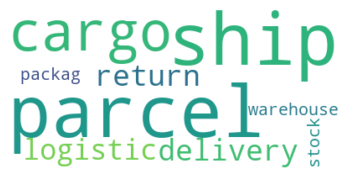

In [17]:
#generation of pictures for presentation
wc = WordCloud(background_color='white', max_words=500, repeat=False)
wc.generate('ship|parcel|cargo|delivery|return|logistic|warehouse|stock|packag)')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
def define_team(df):
    pattern_payment = r"(voucher|pay|money|klarna|refund|PayPal|bank|£|loan|bill|charg|rate|cost|expens|invoice|budget|usd|euro|Promo|discount)"
    pattern_logistics= r"(\sship|parcel|cargo|delivery|return|logistic|warehouse|stock|packag)"
    pattern_weather = r"(Iembot|Iem)"
    pattern_fit = r"(size|fit|waist|small|large|medium|dimensions|extent|measurement|mass|length|volume|proportions|bulk|width|big|huge|adapt|shape|arrange|alter|tailor|adjust|modify|tweak|customize)"
    pattern_search = r"(search|find|inquiry|investigat|examin|pursuit|quest|inspect|explor|check)"


    pattern_catalog = r"(catalog|list)"
    pattern_sustain = r"(tree|green|environment|sustain|natur|climate)"
    pattern_recommendation = r"(recommend|refer|advice|propos|suggest|counsel|guid)"
    pattern_outfit = r"(outfit|costume|dress|cloth|suit|gear|jacket|jean|shirt|style|brand)"
    pattern_tech = r"(devops|technology|automation|application|\sAI\s|kubernetes|restapis|microservice|iOS|Android|app\s|Backend|\sUI\s)"
    pattern_support=r"(help|support|service|email|phone|reach|contact)"
    pattern_account=r"(account|acc\s)"
    pattern_stock=r"(stock|ebit|GMV|earn|forecast|tick|report|annual|loss|GBP|CAC|DAX|FTSE)"

    df['team'] = 'Other'
    for i, row in df.iterrows():
        
        match_logistics = re.findall(pattern_logistics, row.lemma, re.IGNORECASE) 
        if len(match_logistics) > 0:
            df['team'].loc[i] = 'Logistics'

        match_payment = re.findall(pattern_payment, row.lemma, re.IGNORECASE) 
        if len(match_payment) > 0:
            df['team'].loc[i] = 'Payment'

        match_weather = re.findall(pattern_weather, row['name'], re.IGNORECASE) 
        if len(match_weather) > 0:
            df['team'].loc[i] = 'Weather'

        match_fit = re.findall(pattern_fit, row.lemma, re.IGNORECASE) 
        if len(match_fit) > 0:
            df['team'].loc[i] = 'Fit'

        match_search = re.findall(pattern_search, row.lemma, re.IGNORECASE) 
        if len(match_search) > 0:
            df['team'].loc[i] = 'Search'

        match_catalog = re.findall(pattern_catalog, row.lemma, re.IGNORECASE) 
        if len(match_catalog) > 0:
            df['team'].loc[i] = 'Catalog'

        match_sustain = re.findall(pattern_sustain, row.lemma, re.IGNORECASE) 
        if len(match_sustain) > 0:
            df['team'].loc[i] = 'Sustainability'
        
        match_recommend = re.findall(pattern_recommendation, row.lemma, re.IGNORECASE) 
        if len(match_recommend) > 0:
            df['team'].loc[i] = 'Recommendation'

        match_outfit = re.findall(pattern_outfit, row.lemma, re.IGNORECASE) 
        if len(match_outfit) > 0:
            df['team'].loc[i] = 'Outfit'

        match_tech = re.findall(pattern_tech, row.lemma, re.IGNORECASE) 
        if len(match_tech) > 0:
            df['team'].loc[i] = 'Tech'
        
        match_support = re.findall(pattern_support, row.lemma, re.IGNORECASE) 
        if len(match_support) > 0:
            df['team'].loc[i] = 'Support'

        match_account = re.findall(pattern_account, row.lemma, re.IGNORECASE) 
        if len(match_account) > 0:
            df['team'].loc[i] = 'Account'
        
        match_tech = re.findall(pattern_tech, row.lemma, re.IGNORECASE) 
        if len(match_tech) > 0:
            df['team'].loc[i] = 'Tech'

        match_stock = re.findall(pattern_stock, row.lemma, re.IGNORECASE) 
        if len(match_stock) > 0:
            df['team'].loc[i] = 'Stock'
    return df

In [19]:
teams = define_team(data)

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [20]:
#testing results by checking random 10 tweets
sample = teams[(teams.team == 'Stock')&(teams.keyword == 'zalando')].sample(n=10)
for i, row in sample.iterrows():
    print(str(i) + ' ' + sample.name[i] + ' ' + sample.tweet[i])

21259 research_tree A very strong 4Q’20 with 30% revenue growth and 7.4% adj. EBIT margin has led to @Zalando beating FY’20 revenue guidance and achieving margins near the top-end. Report published by @LiberumToday #shares #trading
https://t.co/IwihkT0War https://t.co/Sb6FQb7O9K
24444 makfavero Zalando now says it wants to account for 10 per cent of the entire European fashion market by 2025, seeing GMV triple to €30 billion #retail #data https://t.co/CuvtNxENmW
67401 fairplaytalks The 3rd annual Global #DiversityandInclusion Forum from @DI_Leaders boasts a  line-up of top #Diversity  champions from organisations like @SodexoGroup @IBM @adidas @Unilever @intel @Philips @Twitter @zalando_uk @Merck  @Zurich  etc  https://t.co/3FNvS20QQa via @fairplaytalks
3285 mattu64 @zalando_uk Is the restock notification still in place or do I need to request it again?
106342 Freyjihad all the online retailers that google gives me appears to be chinese dropshipping scams

I found a similar pair from Z

Text(0.5, 1.0, 'English')

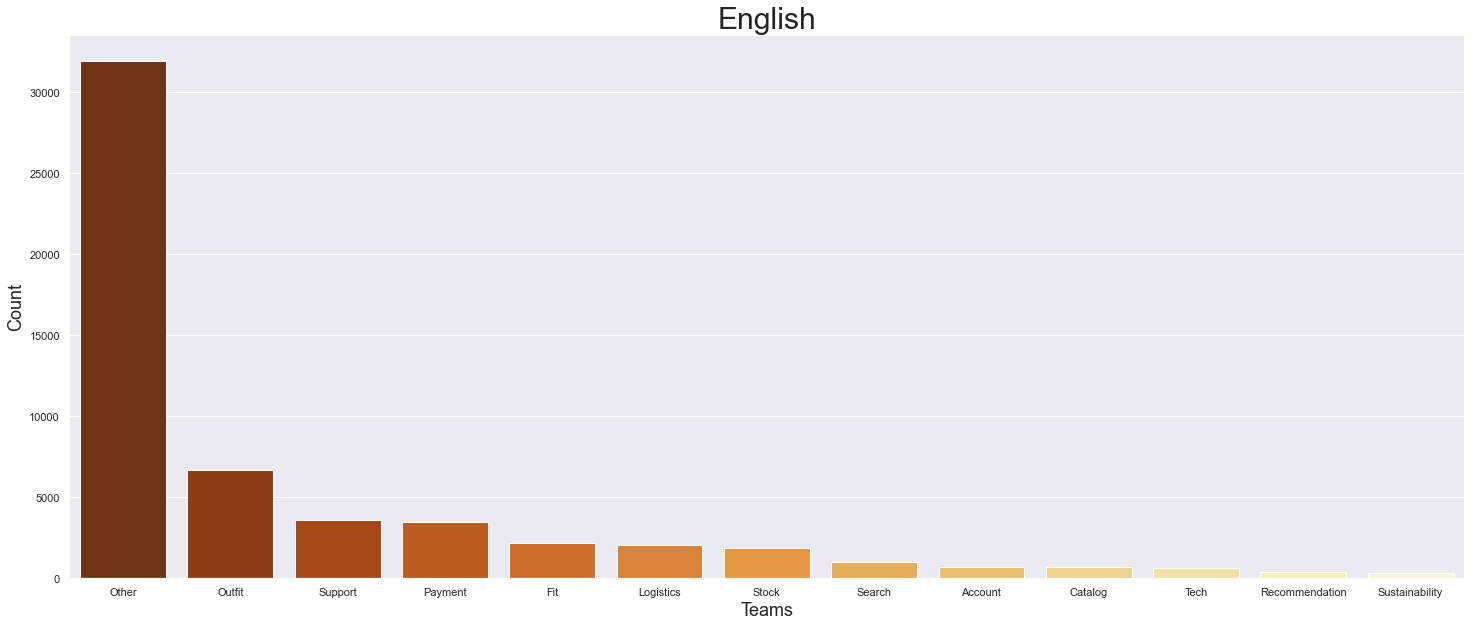

In [71]:
#distribution of tweets for topics
sns.set(rc={'figure.figsize':(25,10)})
b = sns.countplot(data=teams, order = teams['team'].value_counts().index, x='team', palette="YlOrBr_r")
b.set_xlabel("Teams",fontsize=18)
b.set_ylabel("Count",fontsize=18)
b.axes.set_title("English",fontsize=30)

<AxesSubplot:xlabel='keyword', ylabel='count'>

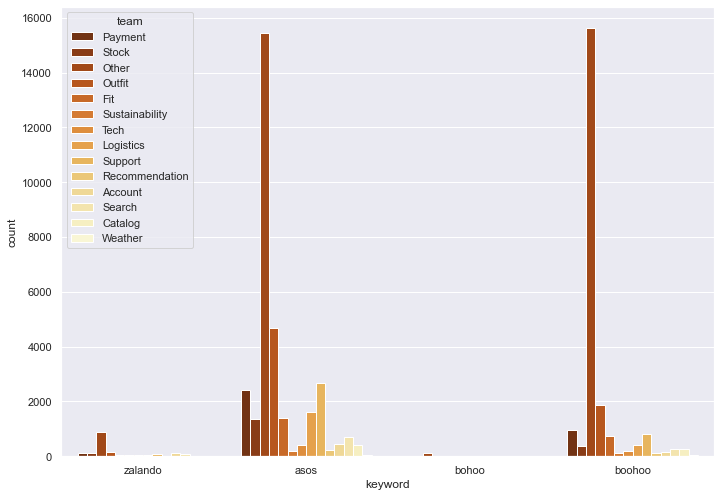

In [22]:
#distribition per topic per company
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data=teams, x='keyword',hue='team', palette="YlOrBr_r")


<AxesSubplot:xlabel='team', ylabel='count'>

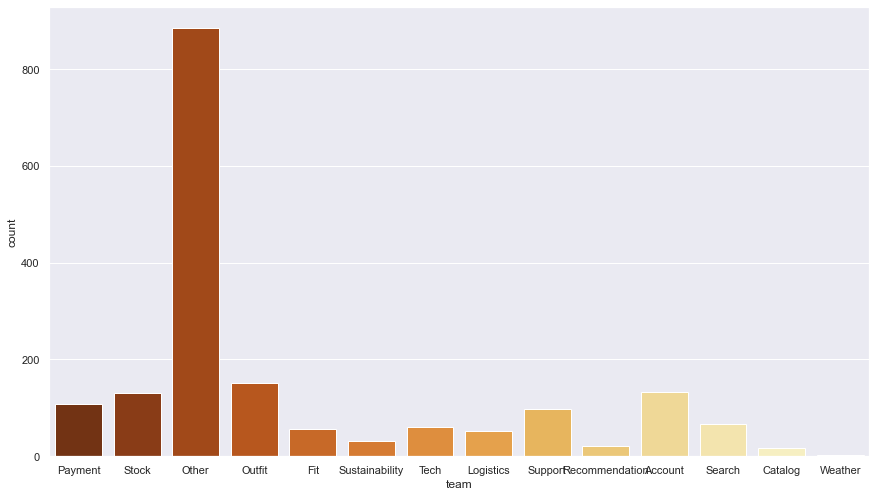

In [23]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.countplot(data=teams[teams['keyword']=='zalando'], x='team', orient='h', palette="YlOrBr_r")

In [24]:
zalando = teams[teams['keyword']=='zalando']

In [25]:
teams = teams[teams['keyword'].isin(['asos','zalando','boohoo'])]
teams = teams.drop(teams[teams['team']=='Weather'].index)


<AxesSubplot:xlabel='team', ylabel='compound'>

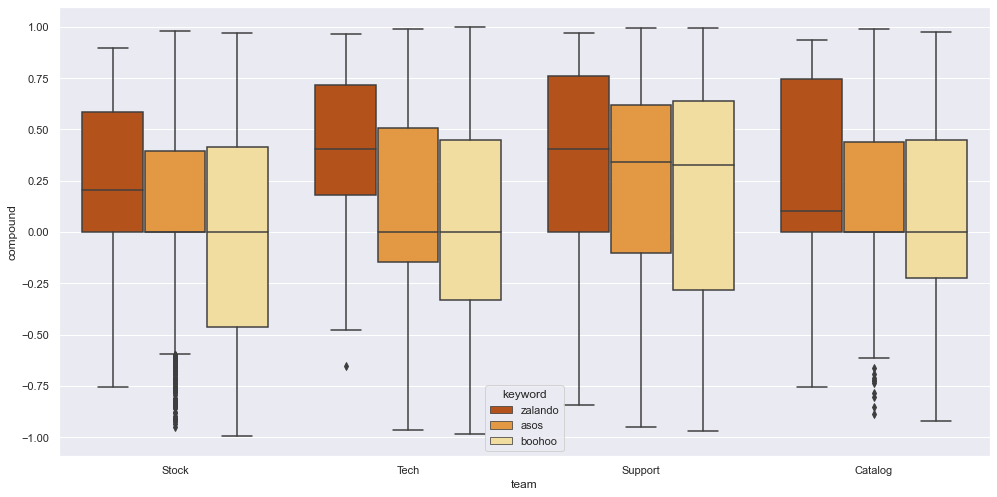

In [86]:
sns.set(rc={'figure.figsize':(16.7,8.27)})
x = teams.loc[teams['team'].isin(['Tech', 'Catalog', 'Support', 'Stock'])]
sns.boxplot(x="team", y="compound", data=x, hue='keyword', palette="YlOrBr_r")


In [ ]:
teams['sentiment'] = teams['compound']
teams['sentiment'] = np.where(teams['sentiment']>=0.5, 1, teams['sentiment'])
teams['sentiment'] = np.where(teams['sentiment']<=-0.5, -1, teams['sentiment'])
teams['sentiment'] = np.where((teams['sentiment']>-0.5)&(teams['sentiment']<0.5), 0, teams['sentiment'])

In [28]:
teams.head()

,index,user_id,user_statuses,name,tweet,retweets,location,created,followers,is_user_verified,...,in_reply_to_status_id,keyword,language,clean,clean_vader,compound,lemma,bot,team,sentiment
0,0,819101311715131392,77,Ali09685762,@Zalando give me my money you owe me!!!,0,,07-Mar-2021,6,False,...,NaN,zalando,en,money owe,give money you owe me!!!,0.0000,money owe,False,Payment,0.0
1,1,1189512849472643072,105,Labellerr1,#VirtualStyling and try-on increases the conve...,0,chandigarh,06-Mar-2021,18,False,...,NaN,zalando,en,virtualstyling try increases conversion rate l...,VirtualStyling and try-on increases the conver...,0.7650,virtualstyle try increase conversion rate larg...,False,Stock,1.0
3,3,1125728513666048000,9604,DommeLineCoUk,@missbellalugosi @Zalando Problem starts at Ad...,0,,06-Mar-2021,2193,False,...,1.368196e+18,zalando,en,problem starts adidas selling latex websites,Problem starts Adidas. They're selling latex t...,-0.4019,problem start adida sell latex website,False,Other,0.0
4,4,2614256724,35470,medboyUK,@missbellalugosi @Zalando Welcome to my world ...,0,"West Midlands, UK",06-Mar-2021,2503,False,...,1.368196e+18,zalando,en,welcome world sneering disdain,Welcome world sneering and disdain!,-0.1007,welcome world sneer disdain,False,Other,0.0
5,5,978410484155199488,1549,missbellalugosi,Hey @Zalando these clothes are not made of la...,0,GERMANY / UK / USA,06-Mar-2021,13827,False,...,NaN,zalando,en,hey clothes latex plastic latex rubber stitche...,"Hey these clothes are not made latex, they are...",0.5362,hey clothe latex plastic latex rubber stitch r...,False,Outfit,1.0


In [121]:
pickle.dump(teams, open(r'.\data_n_models\5.eng_df_teams_classified.pkl', 'wb'))

<AxesSubplot:xlabel='team', ylabel='count'>

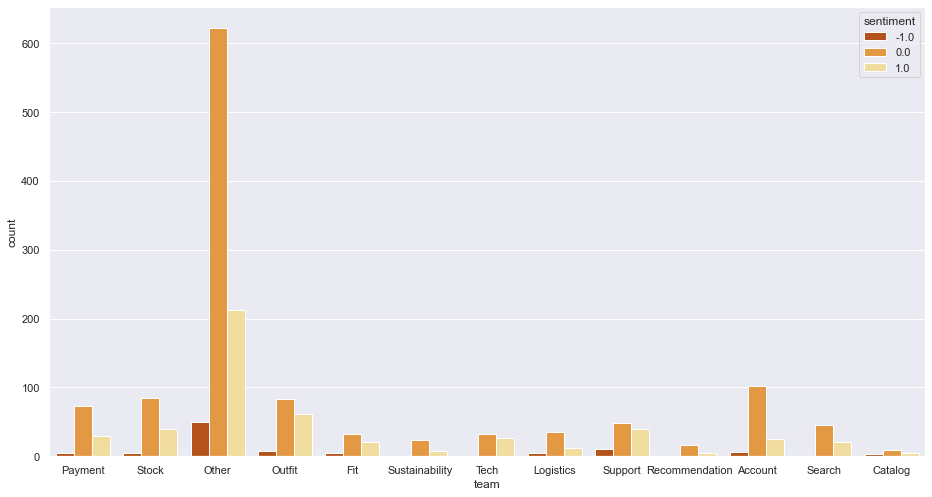

In [29]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.countplot(data=teams[teams['keyword']=='zalando'], x='team',hue='sentiment', palette="YlOrBr_r")

<AxesSubplot:xlabel='team', ylabel='count'>

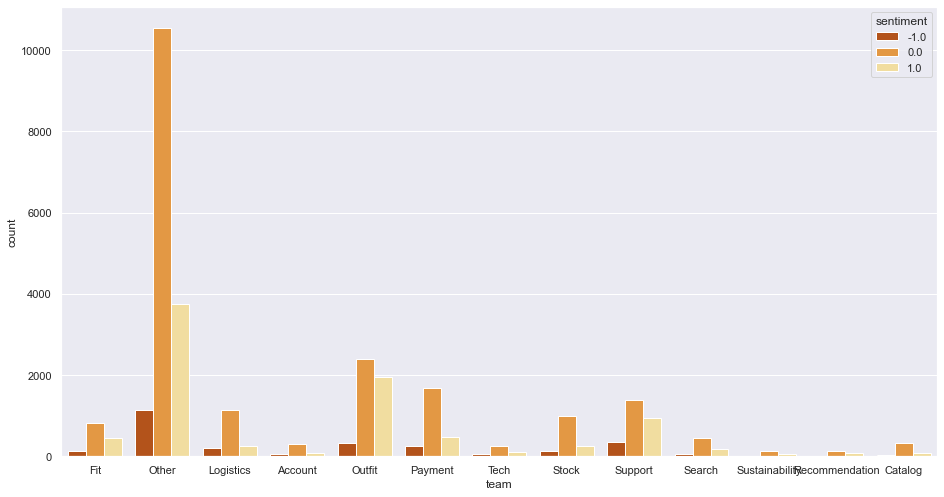

In [30]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.countplot(data=teams[teams['keyword']=='asos'], x='team',hue='sentiment', palette="YlOrBr_r")

In [31]:
#top 10 negative tweets about Zalando
for i, tweet in teams[teams['keyword']=='zalando'].sort_values(by='compound')[:10].iterrows():
    print(tweet.tweet)

Fuck @Zalando @Zalando_Press ! What a negative company history and now this annoying tv commercials ! Who the hell needs that ???
@d0h0k1 @anchor_protocol WTF bro. This blockchain shit doesn't work. After this, I'm quitting my crypto job and applying to Zalando and Deliveroo. Fuck crypto!
I bought two more pairs of shoes this morning, from Zalando Lounge, for summer. Only with the new Covid numbers and slow vaccination we'll probably all sit at home. And cry. I hate the stupid selfishness of people.
@Zalando Have already done so. I am really very dismayed with this terrible process; I have to *prove* that I returned the items, even though Zalando have rec'd parcel &amp; are the ones that have made the mistake. V disappointed; would not shop again at Zalando.
@Zalando get your shit together wtf was that i wasn‘t even able to click on the jordans and they were already sold out what the actual fuck
@Zalando you guys messed up my order almost a month ago and forced the package to be sent b

In [32]:
#functions
def print_tweets(data, keyword, topic, number=10, positive=True):
    for i, tweet in data[(data['keyword']==keyword)&(data['team']==topic)].sort_values(by='compound', ascending= not positive)[:number].iterrows():
        print(tweet.tweet)



In [33]:
print_tweets(teams, 'zalando', 'Support')

Already a year! 🗓 An exciting year full of satisfactions, challenges and mutual support. Proud to be part to this great family ! 🥳🎉🎂@Zalando @ZalandoTech https://t.co/7nKZFTJvGD
💥Hey ... listen up! We still need a super star to help my team. We can provide wonderful challenges seen from an architecture perspective. Clean code. TDD. Autonomy.

In an organization that is becoming truly engineering led. Inspired by Facebook, Spotify, Zalando etc
Zalando hit a 25% growth spurt in 2020 and outgrew its ERP system! To better serve its 35 million customers, the company digitally transformed its innovative fashion platform with SAP #S4HANA to support ambitious growth. https://t.co/NELc9ovOJl https://t.co/NZ8UEHrvpT
Huge thanks to @Zalando &amp; @voluntireland for the fantastic career workshop with our clients yesterday! The team from Zalando offered advice, inspiration and practical CV and interview tips to help our clients on their job hunt. https://t.co/lmYDZRmpWK
A lot of mistakes later it’s

Word Cloud Saved Successfully


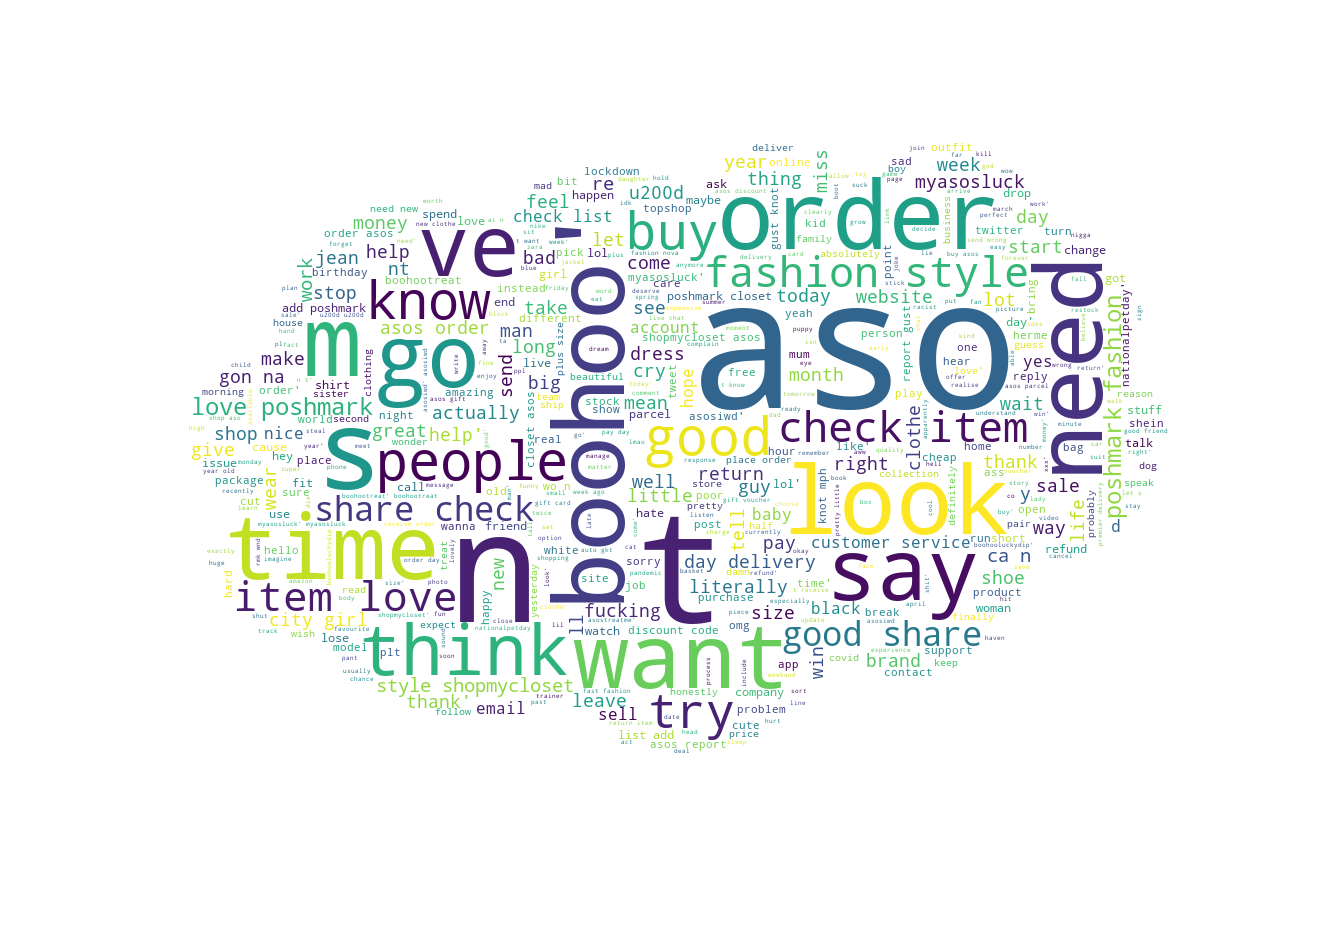

In [34]:
# Function to create a wordcloud
def create_wordcloud(tweet, path='data_n_models\wc_pos.png'):
    """ this function takes in two arguments, the path to save the file and the tweet"""
    mask = np.array(Image.open("data_n_models\cloud.png"))
    stopwords = set(STOPWORDS)
    stopwords.update(["boohoo","boohoo'" "asos","asos'",'Zalando','zalando','fuck',"fuck'", "zalando'",'bitch','shit'])
    wc = WordCloud(background_color='white', mask = mask, max_words=500, stopwords=stopwords, repeat=False)
    tweet = [tweet.strip("'") for tweet in tweet]
    wc.generate(str(tweet))
    wc.to_file(path)
    print('Word Cloud Saved Successfully')
    display(Image.open(path))
#Creating wordcloud for all tweets
create_wordcloud(teams['lemma'].values)

In [35]:
# Extracting the nouns from the text data 
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
# Tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Annelie Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [36]:
teams['tokens'] = teams['lemma'].apply(lambda x: tokenizer.tokenize(x.lower())) # can't only use str as input need list of strings
teams['nouns'] = np.empty((len(teams), 0)).tolist()
teams['adj'] = np.empty((len(teams), 0)).tolist()


In [41]:
import spacy
nlp = spacy.load('en_core_web_sm')

for row in teams.index:
    doc = nlp(teams.lemma[row])
    for i in doc:
        if i.tag_ == 'NN':
            teams.nouns[row].append(i)

Word Cloud Saved Successfully


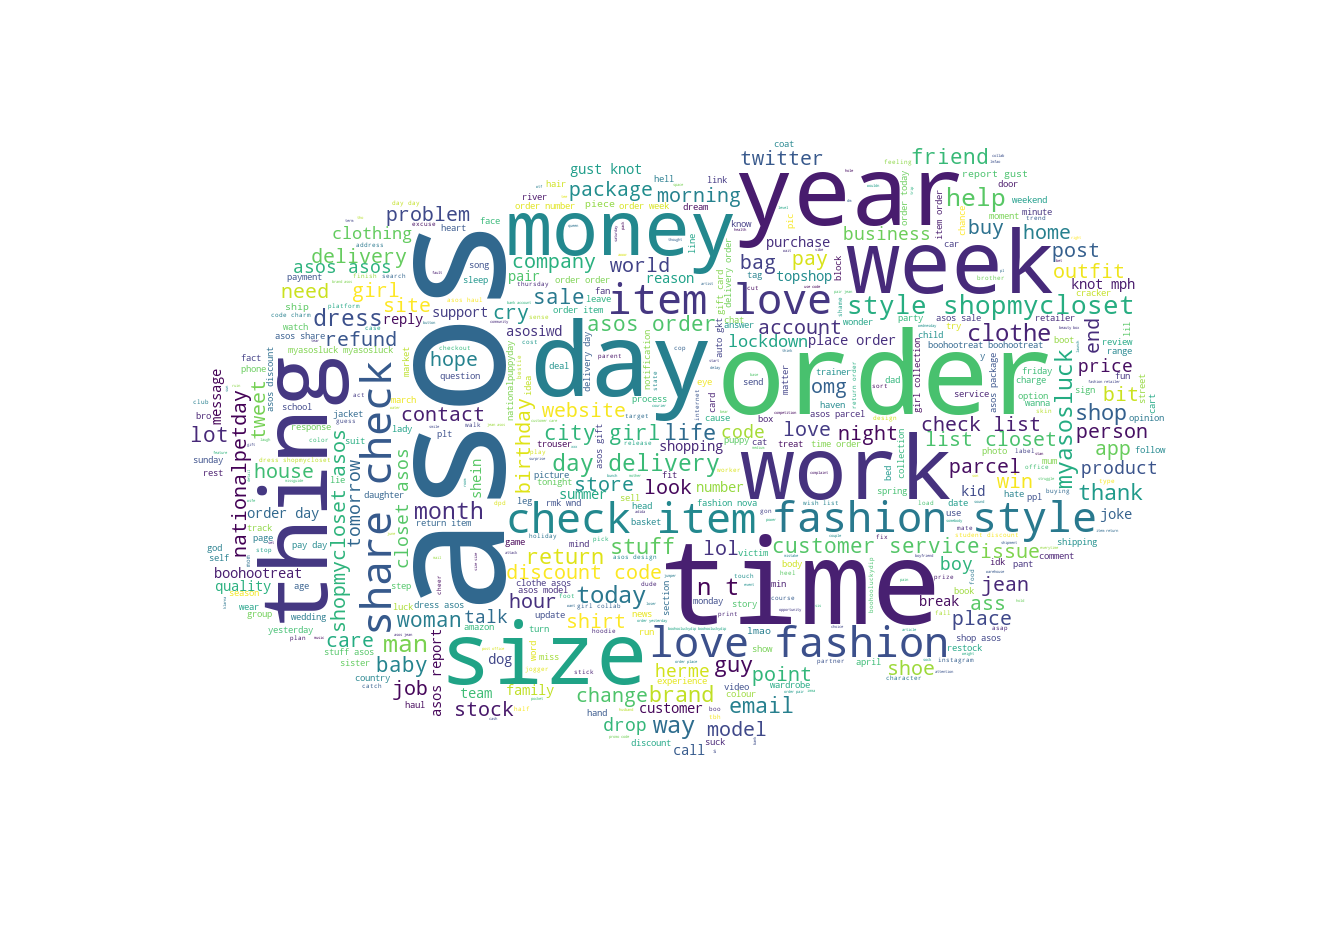

In [54]:
# Function to create a wordcloud from nouns
import itertools
def create_wordcloud(tweet, path='data_n_models\wc_pos.png'):
    """ this function takes in two arguments, the path to save the file and the tweet"""
    mask = np.array(Image.open("data_n_models\cloud.png"))
    stopwords = set(STOPWORDS)
    stopwords.update(["boohoo","boohoo'" "asos","asos'",'Zalando','zalando','fuck',"fuck'", "zalando'",'bitch','shit', 'aso', 'asos ', ' asos'])
    wc = WordCloud(background_color='white', mask = mask, max_words=500, stopwords=stopwords, repeat=False)
    tweet = ' '.join(list(itertools.chain.from_iterable([[token.text for token in document] for document in tweet])))
    wc.generate(str(tweet))
    wc.to_file(path)
    print('Word Cloud Saved Successfully')
    display(Image.open(path))
#Creating wordcloud for all tweets
create_wordcloud(teams['nouns'].values)

Word Cloud Saved Successfully


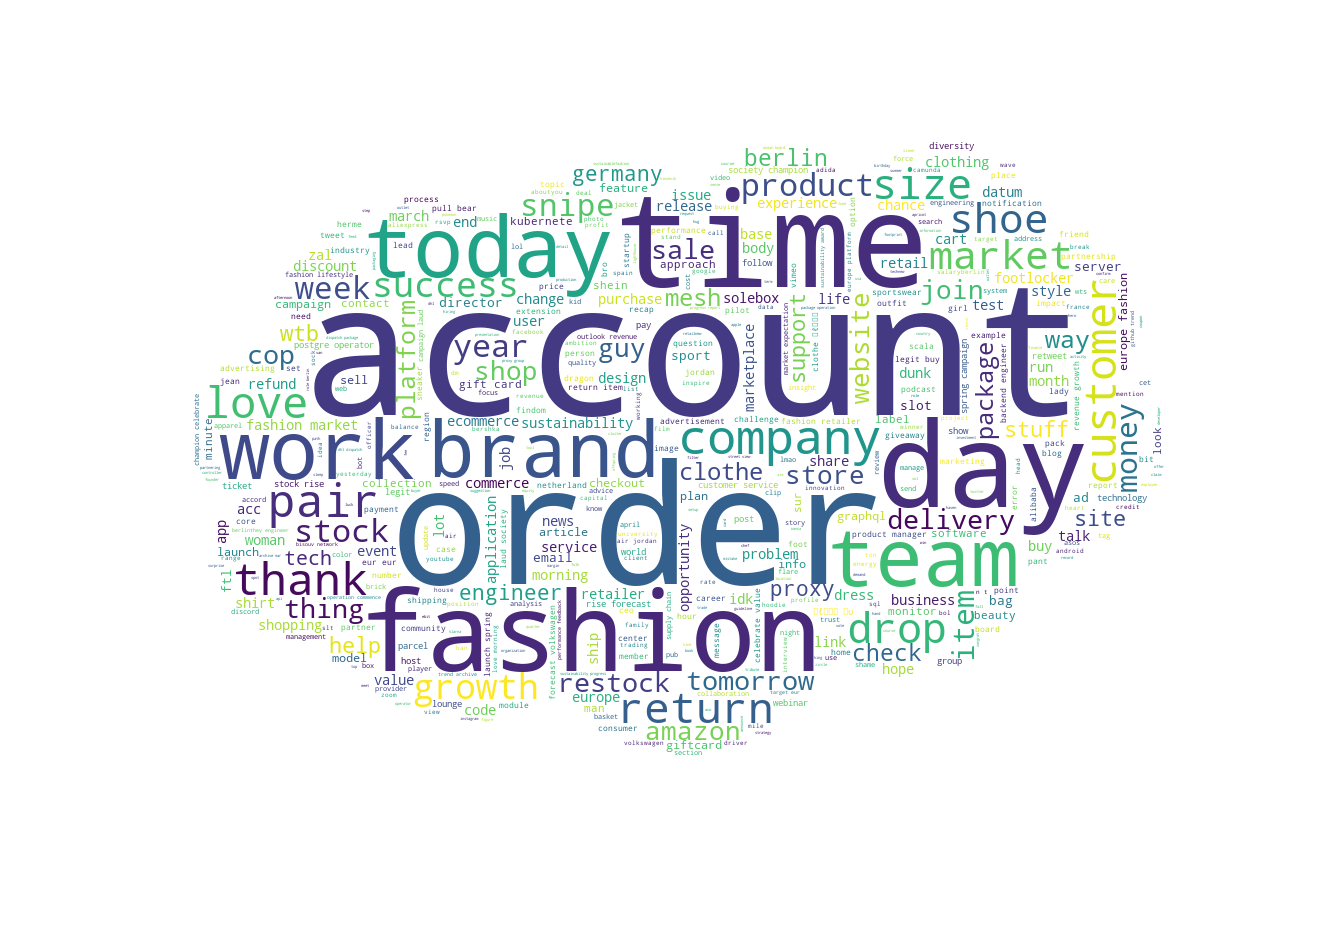

In [51]:
#Creating wordcloud for all Zalando
zalando = teams[teams['keyword']=='zalando']
create_wordcloud(zalando.nouns.values)

Word Cloud Saved Successfully


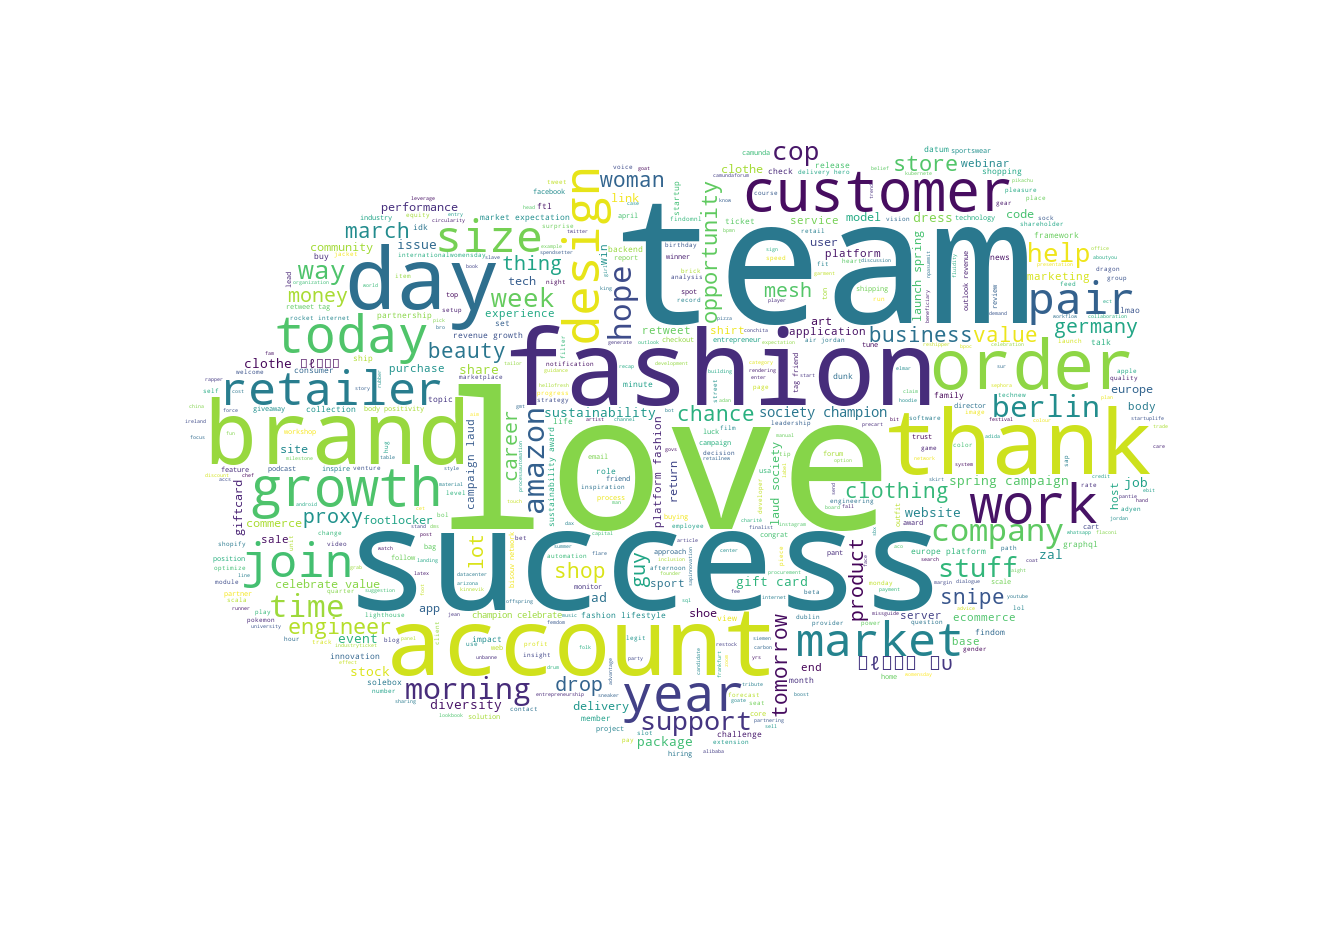

In [46]:
#Creating wordcloud for positive Zalando
pos_zalando = zalando[zalando['sentiment']==1]
create_wordcloud(pos_zalando.nouns.values)

Word Cloud Saved Successfully


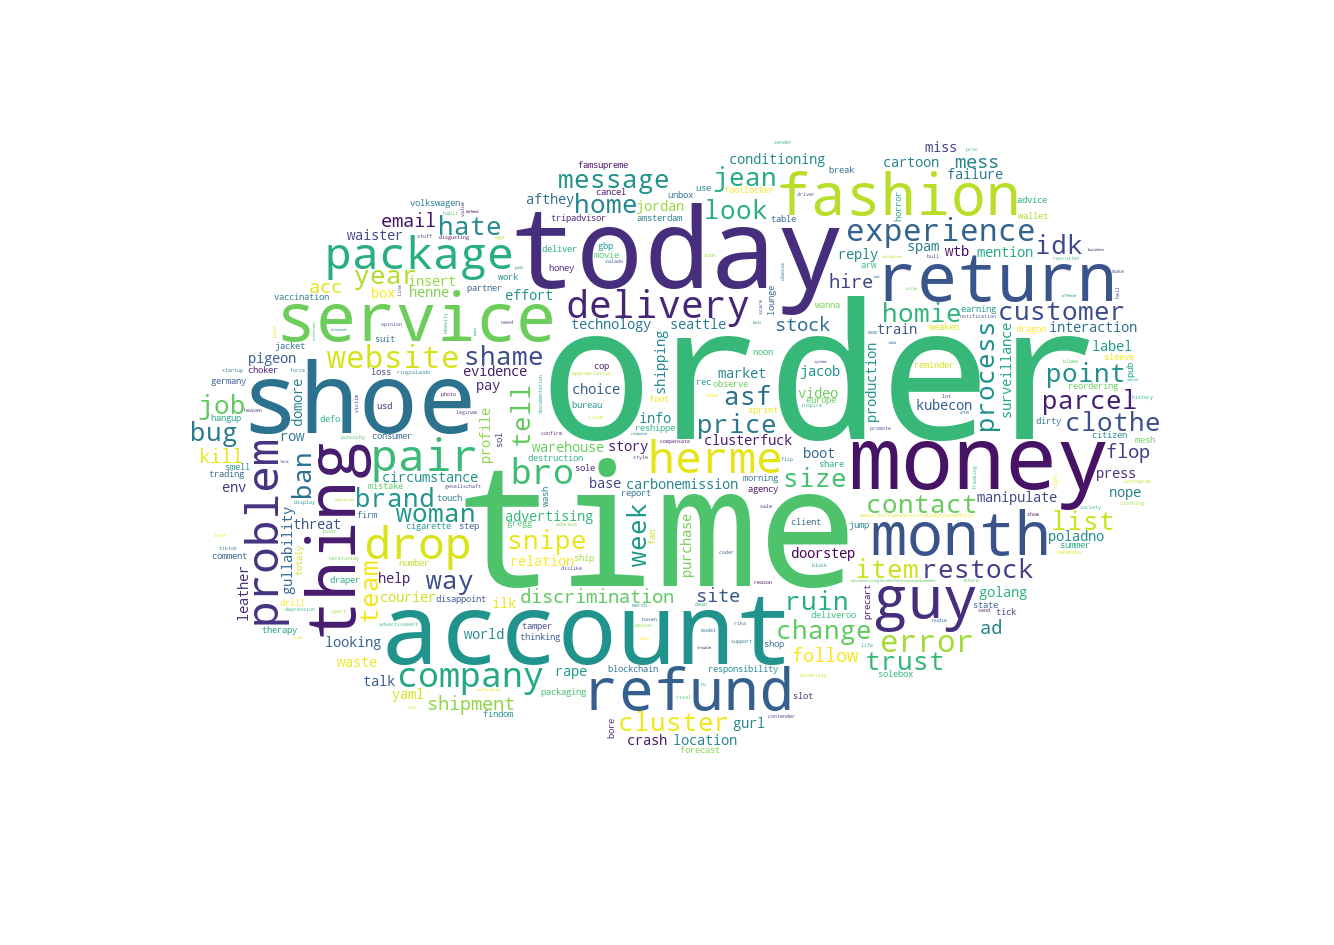

In [47]:
#Creating wordcloud for negative Zalando
neg_zalando = zalando[zalando['sentiment']==-1]
create_wordcloud(neg_zalando.nouns.values)

Word Cloud Saved Successfully


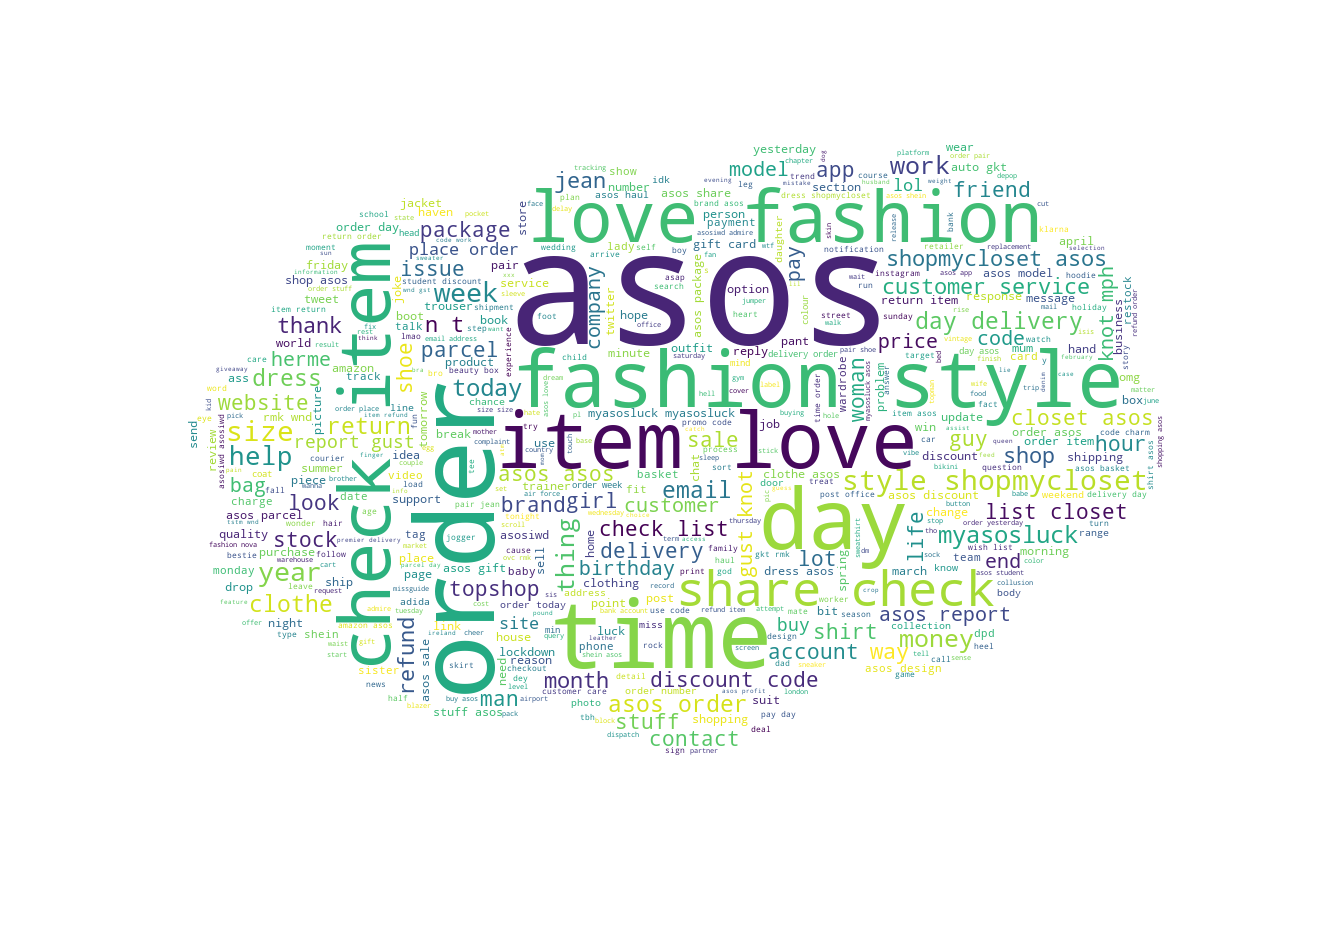

In [55]:
#Creating wordcloud for all asos
asos = teams[teams['keyword']=='asos']
create_wordcloud(asos.nouns.values)

Word Cloud Saved Successfully


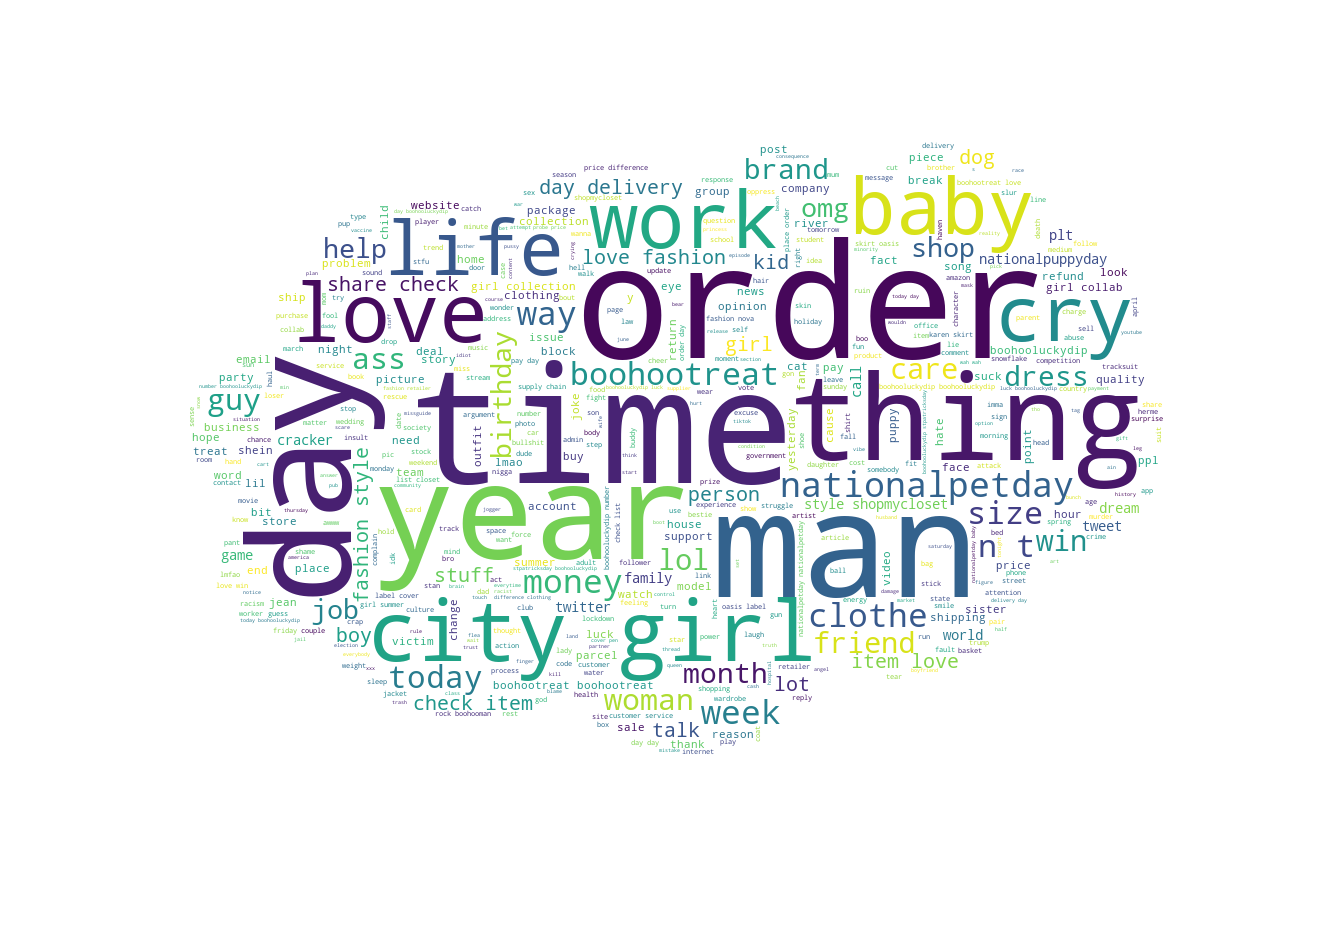

In [53]:
#Creating wordcloud for all asos
boohoo = teams[teams['keyword']=='boohoo']
create_wordcloud(boohoo.nouns.values)